In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('../')
import dataset_wrapper as util

In [ ]:
import ee
ee.Authenticate() 
ee.Initialize()

### Climate data

In [ ]:
county_names = ['Sacramento', 'Alameda', 'Contra Costa', 'Marin', 'Napa', 'San Francisco', 'San Mateo', 'Santa Clara', 'Solano', 'Sonoma']

In [8]:
for name in county_names: 
    for year in range(2022, 2023):
        if year != 2012: 
            dataset = util.DownloadClimateEE(year = year, county_name= name)()

NetCDF file saved to /data2/hkaman/Data/FoundationModel/Sacramento/Climate/2022/DayMet_Sacramento_2022.nc


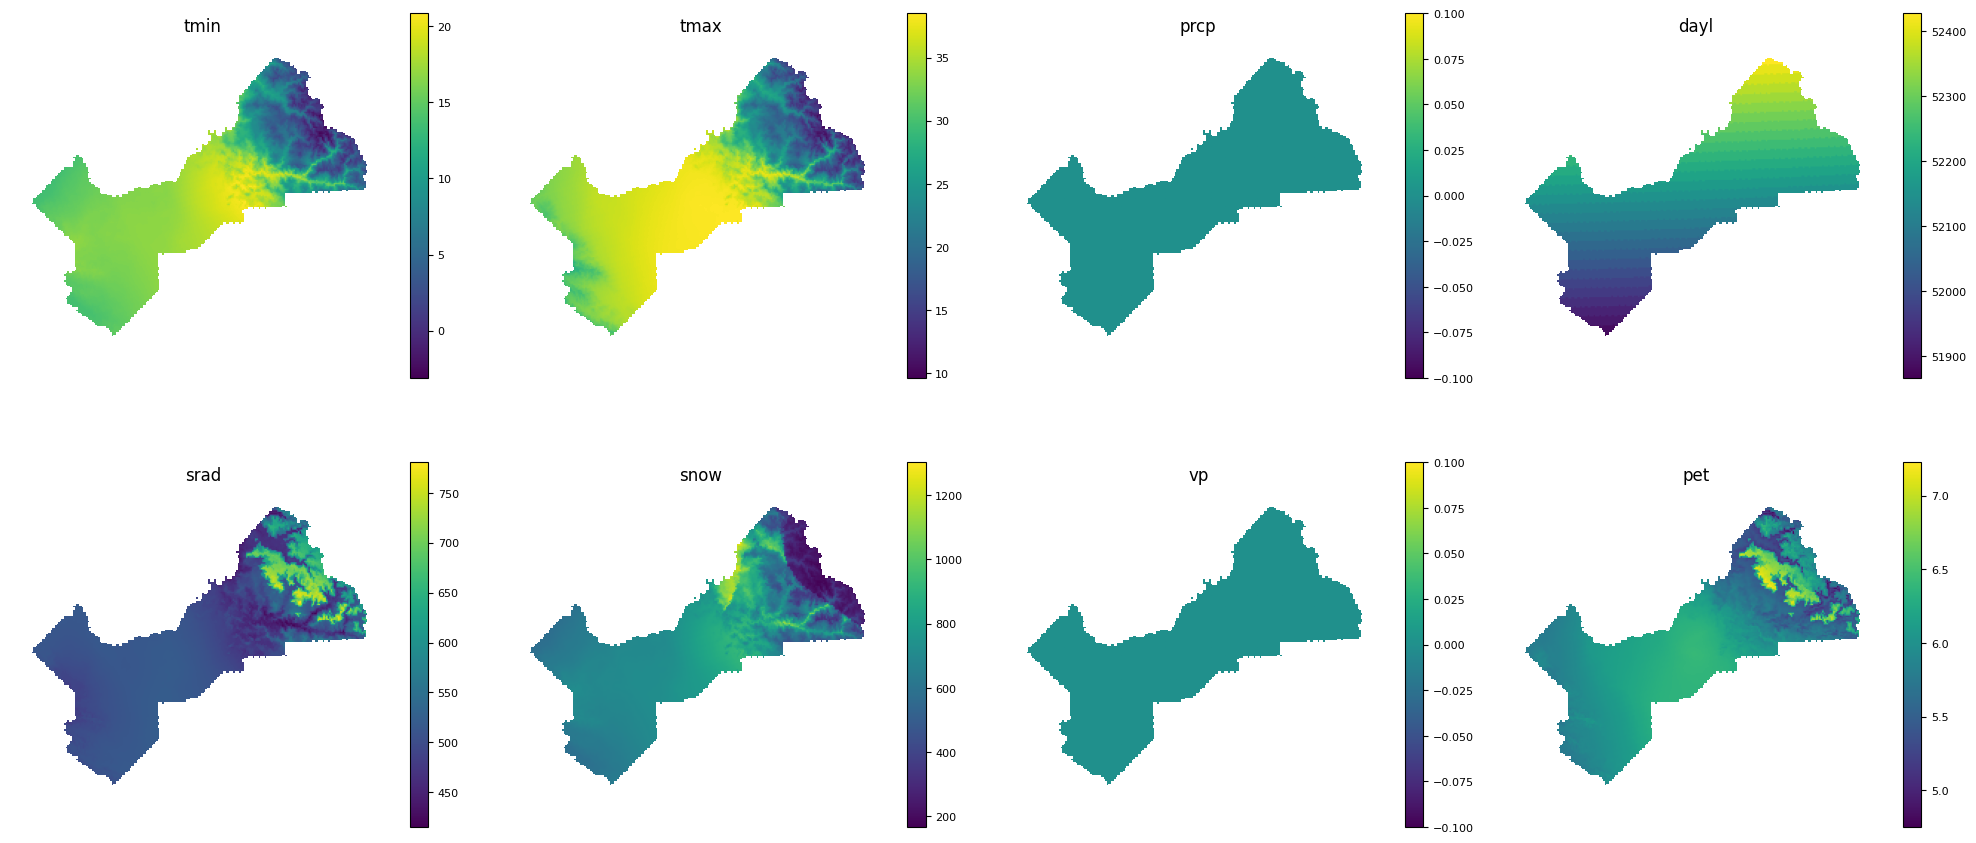

In [ ]:
root_dir = '/data2/hkaman/Data/FoundationModel/Inputs'
county_name = 'Fresno'

util.process_and_plot_daymet_climate(root_dir, county_name, yr = 2022, target_crs="EPSG:32610", daily=True)

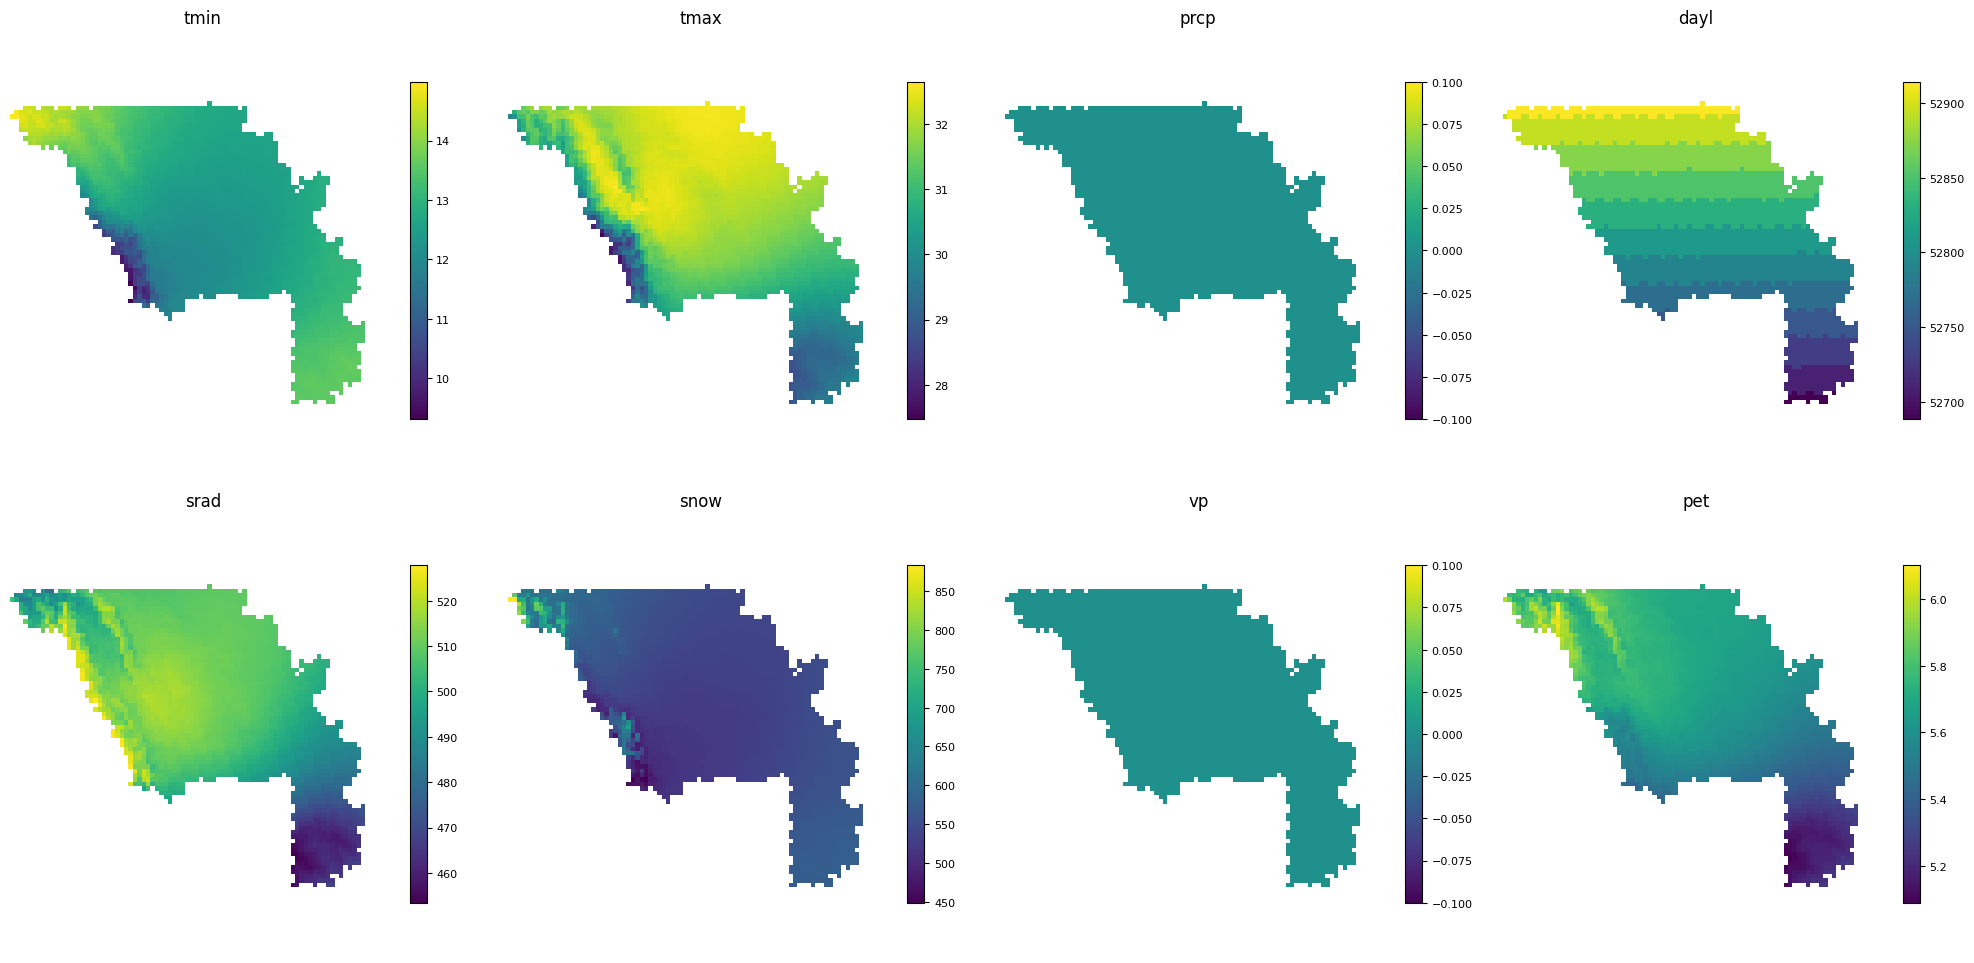

In [ ]:
root_dir = '/data2/hkaman/Data/FoundationModel/Inputs'
county_name = 'Napa'

util.process_and_plot_daymet_climate(root_dir, county_name, yr = 2022, target_crs="EPSG:32610", daily=True)

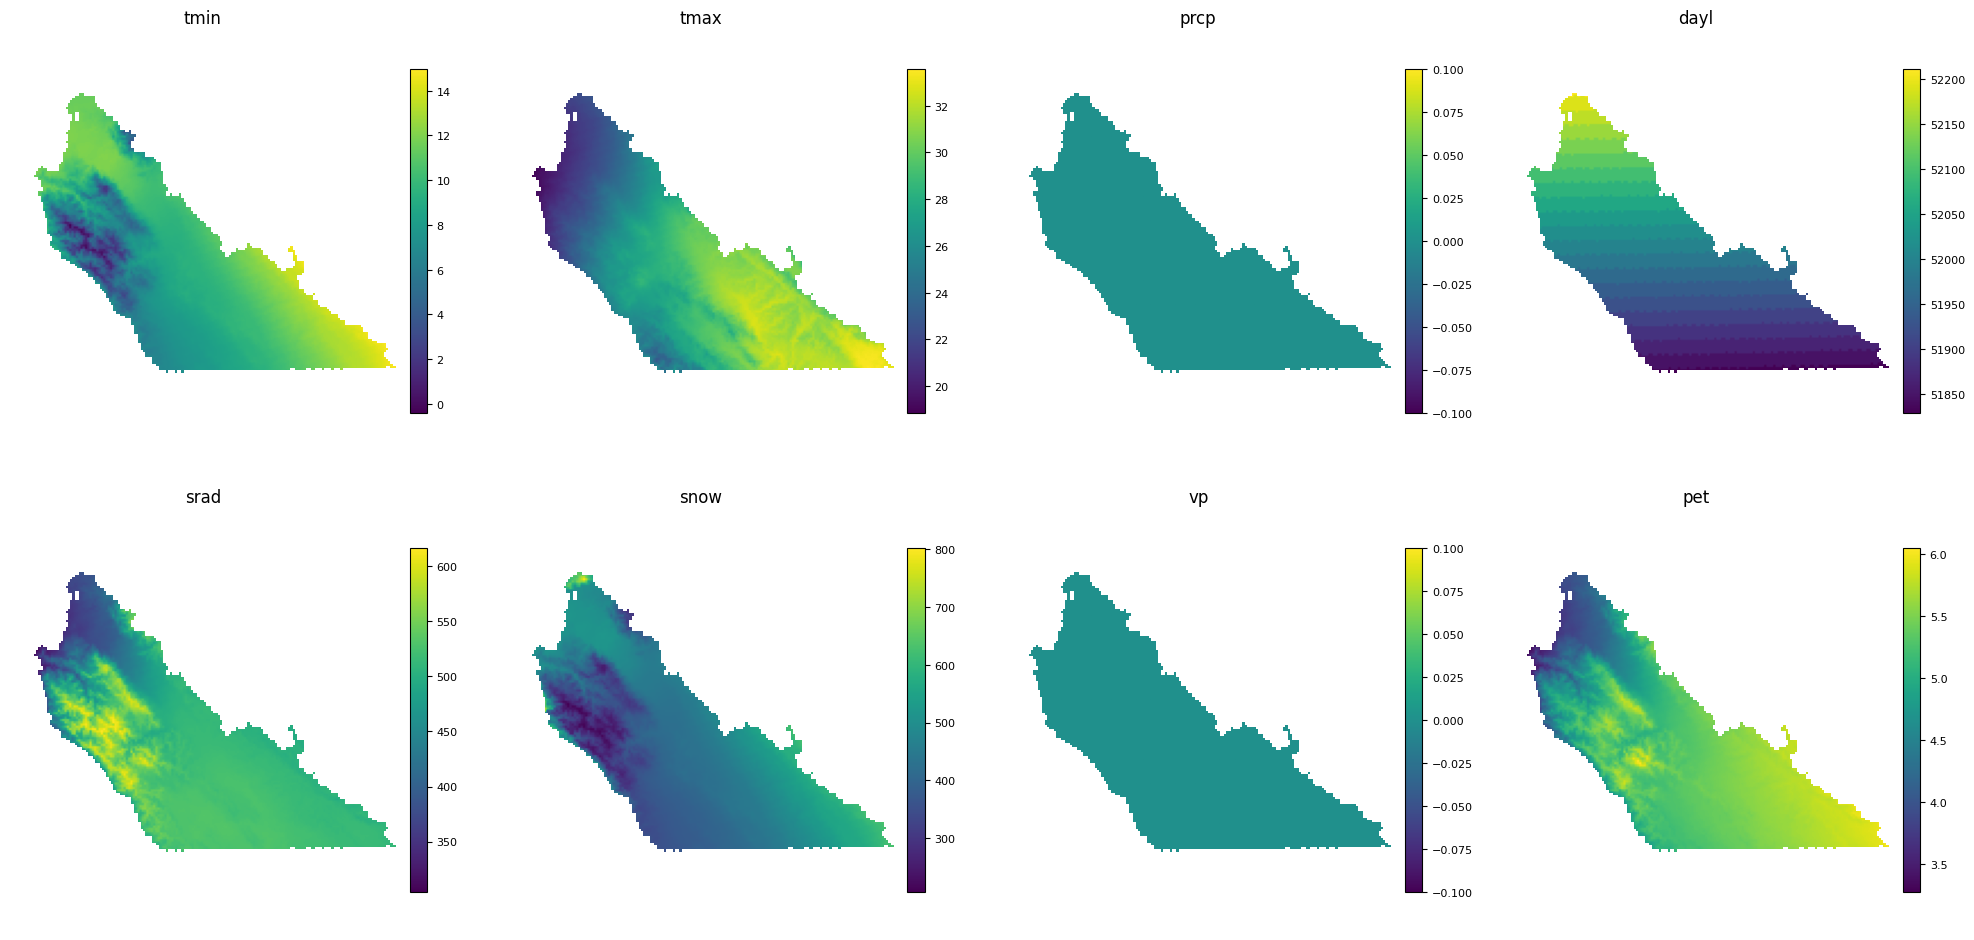

In [ ]:
root_dir = '/data2/hkaman/Data/FoundationModel/Inputs'
county_name = 'Monterey'

util.process_and_plot_daymet_climate(root_dir, county_name, yr = 2022, target_crs="EPSG:32610", daily=True)